In [7]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import csv
import numpy as np
import pandas as pd
import tensorflow as tf
import random

In [8]:
SEED = 0

def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

def set_global_determinism(seed=SEED):
    set_seeds(seed=seed)

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

set_global_determinism(seed=SEED)

In [9]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [22]:
data_folder = "ISIC_Disease"

In [23]:
image_size = 128  
output_csv = "image_features_rgb.csv"  

In [ ]:
import os
import csv
import numpy as np
from PIL import Image

with open(output_csv, "w", newline="") as csvfile:
    writer = csv.writer(csvfile)

    num_pixels = image_size * image_size * 3 
    
    header = [f"Pixel_{i}" for i in range(num_pixels)] + ["Label"]
    writer.writerow(header)
    
    subfolders = [f.path for f in os.scandir(data_folder) if f.is_dir()]
    label_mapping = {}
    
    for i, subfolder in enumerate(subfolders):
        folder_name = os.path.basename(subfolder)
        print(f"Processing folder: {folder_name}, Label: {i}")
        label_mapping[folder_name] = i
        
        image_files = [f for f in os.listdir(subfolder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        for img_file in image_files:
            img_path = os.path.join(subfolder, img_file)
            
            img = Image.open(img_path).convert("RGB")
            img = img.resize((image_size, image_size), Image.BICUBIC)
                
            img_array = np.array(img).flatten()
                
         
            img_array = np.clip(img_array, 0, 255).astype(np.uint8)
                

            row = list(img_array) + [i]
            writer.writerow(row)


Processing folder: Actinic keratosis, Label: 0
Processing folder: Vascular lesion, Label: 1
Processing folder: Melanocytic nevus, Label: 2
Processing folder: Basal cell carcinoma, Label: 3
Processing folder: Squamous cell carcinoma, Label: 4
Processing folder: Dermatofibroma, Label: 5
Processing folder: Melanoma, Label: 6
Processing folder: Benign keratosis, Label: 7
Label Mapping: {'Actinic keratosis': 0, 'Vascular lesion': 1, 'Melanocytic nevus': 2, 'Basal cell carcinoma': 3, 'Squamous cell carcinoma': 4, 'Dermatofibroma': 5, 'Melanoma': 6, 'Benign keratosis': 7}


In [25]:
print("\nLabel Mapping:")
for folder, label in label_mapping.items():
    print(f"{folder}: {label}")


Label Mapping:
Actinic keratosis: 0
Vascular lesion: 1
Melanocytic nevus: 2
Basal cell carcinoma: 3
Squamous cell carcinoma: 4
Dermatofibroma: 5
Melanoma: 6
Benign keratosis: 7


In [26]:
df = pd.read_csv("image_features_rgb.csv")

In [27]:
df['Label'].unique()

array([0, 1, 2, 3, 4, 5, 6, 7])

In [28]:
df.head(1)

,Pixel_0,Pixel_1,Pixel_2,Pixel_3,Pixel_4,Pixel_5,Pixel_6,Pixel_7,Pixel_8,Pixel_9,...,Pixel_49143,Pixel_49144,Pixel_49145,Pixel_49146,Pixel_49147,Pixel_49148,Pixel_49149,Pixel_49150,Pixel_49151,Label
0,67,40,29,72,43,30,82,48,33,90,...,27,18,15,22,15,12,17,12,9,0


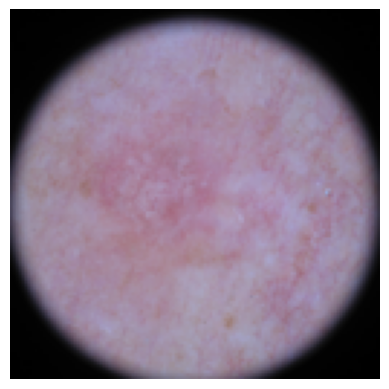

In [31]:
pixel_data = df.drop(columns=["Label"]).iloc[300].values.astype(np.uint8)

image_array = pixel_data.reshape((image_size, image_size, 3))

plt.imshow(image_array)
plt.axis("off")
plt.show()


In [32]:
label_counts = df['Label'].value_counts()

label_counts

Label
2    12875
6     4522
3     3323
7     2624
0      867
4      628
1      253
5      239
Name: count, dtype: int64

In [34]:
major_class = df[df['Label'].isin([2, 6, 3, 7])]
minor_class = df[df['Label'].isin([0, 4, 1 ,5])]

In [35]:
major_class['Label'].value_counts()

Label
2    12875
6     4522
3     3323
7     2624
Name: count, dtype: int64

In [36]:
target_size = 3000

def oversample(group, size):
    if len(group) >= size:
        return group.sample(n=size, random_state=42)
    else:
        oversample = group.sample(n=size, replace=True, random_state=42)
        return oversample
    
major_class = major_class.groupby('Label').apply(lambda x: oversample(x, target_size)).reset_index(drop=True)

major_class['Label'].value_counts()

/tmp/ipykernel_26236/1671438094.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  major_class = major_class.groupby('Label').apply(lambda x: oversample(x, target_size)).reset_index(drop=True)


Label
2    3000
3    3000
6    3000
7    3000
Name: count, dtype: int64

In [37]:
minor_class['Label'].value_counts()

Label
0    867
4    628
1    253
5    239
Name: count, dtype: int64

In [38]:
target_size = 300

minor_class = minor_class.groupby('Label').apply(lambda x: oversample(x, target_size)).reset_index(drop=True)

minor_class['Label'].value_counts()

/tmp/ipykernel_26236/2432684741.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  minor_class = minor_class.groupby('Label').apply(lambda x: oversample(x, target_size)).reset_index(drop=True)


Label
0    300
1    300
4    300
5    300
Name: count, dtype: int64

In [39]:
major_class.to_csv('major_class.csv', index = False)

In [40]:
minor_class.to_csv('minor_class.csv', index = False)